# 0 Set paths, devices, etc.

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

In [2]:
import numpy as np
import pandas as pd
# from collections import Counter
import torch
# from tqdm import tqdm
# from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from datasets import Dataset, DatasetDict

# from huggingface_hub import notebook_login

import torch.nn as nn

from transformers import AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, PreTrainedTokenizerFast, AdamW, GPT2ForSequenceClassification
from transformers import default_data_collator #, LongformerForSequenceClassification, LongformerModel, LongformerConfig, DataCollatorWithPadding
from sklearn.metrics import f1_score, confusion_matrix #, accuracy_score, precision_score, recall_score
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import accelerate

accelerate.__version__

'0.28.0'

In [ ]:
# notebook_login()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_dir = 'drive/MyDrive/neuro2voc/task_1/data/'
# data_dir = '/home/zubat/Fei/Task_1/outputs/'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



# 1 Load data and inspect

### 1.0 select what you want to load

In [7]:
# file = 1
# file = 2
# file = 3
file = "all"


batch_size = 1
# batch_size = 30
# batch_size = 60
# batch_size = 120
# batch_size = 300

# mode = "temporal"
mode = "spatial"

### 1.1 Load the data

In [8]:
data_labels_dir = data_dir+"3_data_labels_df_"+mode+"/"
data_labels_df = pd.read_csv(f"{data_labels_dir}data_labels_{file}_{batch_size}.csv")
current_label_name = 'labels'

In [9]:
# If you need to rename column:
# data_labels_df.rename(columns={'labels': 'label'}, inplace=True)
# result_df_path_name = f"{data_labels_dir}data_labels_{file}_{batch_size}_new.csv"
# data_labels_df.to_csv(result_df_path_name, index=False)
# data_labels_df = pd.read_csv(f"{data_labels_dir}data_labels_{file}_{batch_size}_new.csv")
# current_label_name = 'label'

In [10]:
data_labels_df

,data,labels
0,<|start|>0000000000000000000000000000000000000...,0
1,<|start|>0000000000000000000000000000000000000...,0
2,<|start|>0000000000000000000000000000000000000...,0
3,<|start|>0000000000000000000000000000000000000...,0
4,<|start|>0000000000000000000000000000000000000...,0
...,...,...
7639648,<|start|>0000000000000000000000000000000000000...,3
7639649,<|start|>0000000000000000000000000000000000000...,3
7639650,<|start|>0000000000000000000000000000000000000...,3
7639651,<|start|>0000000000000000000000000000000000000...,3


In [ ]:
data_labels_df['data'][0]

'<|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|>'

#### 1.1.1 Downsample if needed

In [ ]:
downsample_rate = 50000

In [ ]:
downsampled_df, _ = train_test_split(data_labels_df, test_size=1-downsample_rate/len(data_labels_df), stratify=data_labels_df[current_label_name], random_state=42)
data_labels_df = downsampled_df
max(data_labels_df[current_label_name])

6

#### 1.1.2 With two-way classification if needed

In [ ]:
# data_labels_df = data_labels_df[data_labels_df[current_label_name].isin([0, 1])]
# print(max(data_labels_df[current_label_name]))
# data_labels_df

### 1.2 Converting df to dataset

In [11]:
dataset = Dataset.from_pandas(data_labels_df)
# assert len(dataset[current_label_name])==len(dataset['data'])
assert len(dataset[current_label_name])==len(dataset['data'])
dataset

Dataset({
    features: ['data', 'labels'],
    num_rows: 7639653
})

### 1.3 Load tokenizer trained from the previous step

In [12]:
tokenizer_dir = f"{data_dir}4_tokenizer/{mode}_all_{batch_size}"
tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_dir)
print("Loaded tokenizer:")
print(f"Path: {tokenizer_dir}")
print(f"Mode: {mode}")
print(f"Batch: {batch_size}")
print(f"File: {file}")

Loaded tokenizer:
Path: drive/MyDrive/neuro2voc/task_1/data/4_tokenizer/spatial_all_1
Mode: spatial
Batch: 1
File: all


# 2 Prepare for the model

### 2.1 Tokenize function

In [13]:
# no max length, no truncation
def tokenize_function(examples):
    return tokenizer(examples["data"])

# def tokenize_function(examples):
#     return tokenizer(examples["text"], max_length=512, truncation=True)

In [ ]:
tokenizer.model_max_length

1000000000000000019884624838656

In [14]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/7639653 [00:00<?, ? examples/s]

In [15]:
# Play around with the data

untokenized_sample = data_labels_df['data'][0]
tokenized_sample = tokenizer(untokenized_sample)
print(untokenized_sample)
print(tokenized_sample)
print(len(tokenized_sample['input_ids']))

<|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|>
{'input_ids': [0, 12, 1], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}
3


In [ ]:
# from tqdm import tqdm

# for n in tqdm(range(7639653)):
#     if len(tokenized_dataset[n]['input_ids']) > 3:
#         print(n)

### 2.2 Train Test Split

In [16]:
# 0.7 train
train_rest_split = tokenized_dataset.train_test_split(test_size=0.3)
# 0.15 val + 0.15 test
val_test_split = train_rest_split['test'].train_test_split(test_size=0.5)

dataset_dict = DatasetDict({
    'train': train_rest_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})

### 2.3 Data collator

In [17]:
data_collator = default_data_collator

In [18]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

### 2.4 Model

#### 2.4.1 Number of labels

In [19]:
print("number of labels =", max(tokenized_dataset[current_label_name])-min(tokenized_dataset[current_label_name])+1)
if file != "all":
    assert max(tokenized_dataset[current_label_name]) < 6
else:
    assert max(tokenized_dataset[current_label_name]) < 8
assert min(tokenized_dataset[current_label_name]) >= 0
if max(tokenized_dataset[current_label_name]) == 1:
    print("Check if you are doing a binary classification.")

number of labels = 7


In [20]:
num_labels = 7
# num_labels = 6
# num_labels = 2
if num_labels == 7:
    assert file == "all"

### 2.4.2 Load the model

In [26]:
from transformers import GPT2Config, GPT2Model

configuration = GPT2Config(vocab_size = 7107, bos_token_id = 0, eos_token_id = 1)
model = GPT2Model(configuration)
configuration = model.config

In [ ]:
print(tokenizer)

PreTrainedTokenizerFast(name_or_path='/home/zubat/Fei/Task_1/outputs/4_tokenizer/spatial_all_1', vocab_size=7107, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	7107: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [ ]:
print(configuration)

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 7107
}



In [ ]:
print(model)

GPT2Model(
  (wte): Embedding(7107, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [ ]:
# checkpoint = 'bert-base-uncased'
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6) # 7 for data3 & combined data

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model = GPT2ForSequenceClassification.from_pretrained("microsoft/DialogRPT-updown", num_labels=num_labels, ignore_mismatched_sizes=True)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialogRPT-updown and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([1, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=1024, out_features=7, bias=False)
)

In [ ]:
# model = AutoModel.from_pretrained("allenai/longformer-base-4096", num_labels=6)

In [ ]:
# model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=6)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.5 Training arguments

#### 2.5.1 Metrics

In [22]:
metric = evaluate.load("accuracy")

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### 2.5.2 Training Arguments

In [24]:
training_args = TrainingArguments(
    output_dir = "./results",
    num_train_epochs = 10,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    evaluation_strategy = "epoch",
    gradient_accumulation_steps = 64,
    learning_rate = 1.25e-5,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = "./logs"
)

# training_args = TrainingArguments(
#     output_dir = "./results",
#     num_train_epochs = 10,
#     per_device_train_batch_size = 16,
#     per_device_eval_batch_size = 16,
#     gradient_accumulation_steps = 4,
#     evaluation_strategy = "epoch",
#     learning_rate = 5e-5,
#     warmup_steps = 500,
#     weight_decay = 0.01,
#     logging_dir = "./logs",
# )

In [ ]:
# optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = AdamW(model.parameters(), lr=1e-5)

### 2.6 Wrap everything above into trainer

In [25]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = dataset_dict['train'],
    eval_dataset = dataset_dict['validation'],
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
    data_collator = data_collator
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
dataset_dict['train']

Dataset({
    features: ['data', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5347757
})

# 3 TRAIN

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# 4 Test

In [ ]:
test_result = trainer.evaluate(dataset_dict['train'])
print(test_result)

                                                       
 57%|█████▋    | 3000/5240 [6:17:30<1:54:27,  3.07s/it]

{'eval_loss': 1.3781766891479492, 'eval_accuracy': 0.4679506290620714, 'eval_runtime': 270.9478, 'eval_samples_per_second': 61.898, 'eval_steps_per_second': 61.898, 'epoch': 11.45}
{'eval_loss': 1.3781766891479492, 'eval_accuracy': 0.4679506290620714, 'eval_runtime': 270.9478, 'eval_samples_per_second': 61.898, 'eval_steps_per_second': 61.898, 'epoch': 11.45}


In [ ]:
predictions = trainer.predict(dataset_dict['test'])
logits = predictions.predictions
predicted_classes = np.argmax(logits, axis=1)
true_labels = dataset_dict['test']['labels']

# 5 Result

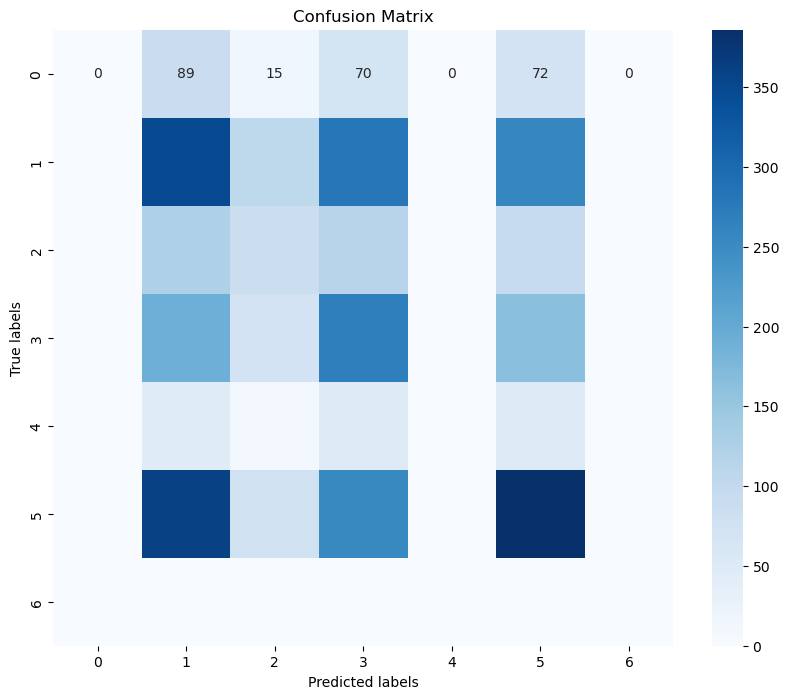

In [ ]:
cm = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


temporal 120: doesnt work, predict only label 1 and 5

spatial data: doesnt work, predict only label

for binary classification


 77%|███████▋  | 1802/2340 [37:25<10:22,  1.16s/it]
{'eval_loss': 0.8176514506340027, 'eval_accuracy': 0.78, 'eval_runtime': 65.3502, 'eval_samples_per_second': 10.712, 'eval_steps_per_second': 3.581, 'epoch': 7.7}

In [ ]:
name_model = "temporal_from_300ms_gpt2_5h/"
trainer.save_model(f"{data_dir}5_models/{name_model}")

# Archived Codes

In [ ]:
class SPKDataset(Dataset):
    def __init__(self, dataset, label, split='train'):
        self.dataset = dataset
        self.split = split
        self.label = label
        self.label2id = {label: label - 2 for label in range(2, 9)}

    def __getitem__(self, item):
        data = self.dataset[item]
        label = self.label[item]
        mapped_label = self.label2id.get(label, label)
        return data, mapped_label

    def __len__(self):
        return len(self.dataset)

In [ ]:
class SPKNoPadCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        data, labels = zip(*batch)

        # tokenizer without padding and truncation
        inputs = self.tokenizer(list(data), return_tensors='pt')

        # extract input_ids and attention_mask
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return input_ids, attention_mask, labels_tensor

In [ ]:
class SPKPadCollator:
    def __init__(self, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        data, labels = zip(*batch)

        # tokenize WITH padding
        input_ids = []
        attention_mask = []
        for datapoint in data:
            encoded = self.tokenizer.encode(datapoint)
            ids = encoded.ids

            # truncate
            ids = ids[:self.max_len]

            # create attention mask and pad input_ids
            mask = [1] * len(ids)
            num_pad = self.max_len - len(ids)
            ids += [self.tokenizer.token_to_id("[PAD]")] * num_pad
            mask += [0] * num_pad

            input_ids.append(ids)
            attention_mask.append(mask)

        # convert to tensors
        input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
        attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return input_ids_tensor, attention_mask_tensor, labels_tensor


In [ ]:
def create_dataloader(data, labels, tokenizer, batch_size=64, shuffle=True, max_len=512):
    dataset = SPKDataset(data, labels)
    collator = SPKCollator(tokenizer, max_len=max_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collator, num_workers=0)
    return dataloader

In [ ]:
train_loader = create_dataloader(X_train, y_train, wrapped_tokenizer, batch_size=16, shuffle=True, max_len=512)
val_loader = create_dataloader(X_val, y_val, wrapped_tokenizer, batch_size=16, shuffle=False, max_len=512)
test_loader = create_dataloader(X_test, y_test, wrapped_tokenizer, batch_size=16, shuffle=False, max_len=512)

In [ ]:
class_weights_tensor = torch.tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
def train(model, loader, optimizer, mode='train'):
  if mode == 'train':
    model.train()
  else:
    model.eval()

  device = torch.device('cuda')
  amp = True
  scalar = torch.cuda.amp.GradScaler(enabled=amp)
  model.to(device)

  all_predictions = []
  all_labels = []

  for _, (input_ids, attention_mask, aligned_labels) in enumerate(loader):
    input_ids, attention_mask, aligned_labels = input_ids.to(device), attention_mask.to(device), aligned_labels.to(device)

    # use fp16 to speed up
    with torch.cuda.amp.autocast(enabled=amp):

      # feed the input to the model
      outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), labels=aligned_labels.to(device))

      # compute the loss
      loss = outputs.loss
      # loss = loss_fn(outputs.logits, aligned_labels.to(torch.float32)) # with weighted loss
      # loss = loss_fn(outputs.logits, aligned_labels.to(torch.float32)) # with weighted loss

      # store the predictions and labels

      cur_predictions = outputs.logits.argmax(dim=-1).data.cpu().numpy().tolist()
      cur_labels = aligned_labels.data.cpu().numpy().tolist()

      # Check if cur_predictions is a list of lists or a list of ints
      if all(isinstance(item, list) for item in cur_predictions):
        # flatten cur_predictions and cur_labels if they are lists of lists
        cur_predictions = [item for sublist in cur_predictions for item in sublist]
        cur_labels = [item for sublist in cur_labels for item in sublist]

      all_predictions.extend(cur_predictions)
      all_labels.extend(cur_labels)

    # print('{} step {} loss: {}'.format(mode, idx, loss.data.cpu().numpy()))
    if mode == 'train':
      # update the model parameters
      optimizer.zero_grad()
      if scalar is not None:
        scalar.scale(loss).backward()
        scalar.step(optimizer)
        scalar.update()
      else:
        loss.backward()
        optimizer.step()
  return all_predictions, all_labels

#optim = torch.optim.Adam(model.parameters(), lr=1e-5)
#predictions, labels = train(model, train_1k_loader, optim, mode='train')
#true_labels, true_predictions = postprocess(predictions, labels)
#print()

In [ ]:
def obtain_performance(model, train_loader, val_loader, optim):
  best_val_micro_f1 = 0
  best_val_macro_f1 = 0
  best_val_macro_epoch = 0
  best_val_micro_epoch = 0
  for epoch in range(10):
    print('===================== Epoch {} ===================='.format(epoch))
    train_predictions, train_labels = train(model, train_loader, optim, mode='train')
    val_predictions, val_labels = train(model, val_loader, optim, mode='eval')
    # train_true_labels, train_true_predictions = postprocess(train_predictions, train_labels)
    # val_true_labels, val_true_predictions = postprocess(val_predictions, val_labels)
    train_true_labels = train_labels
    train_true_predictions = train_predictions
    val_true_labels = val_labels
    val_true_predictions = val_predictions
    # micro f1
    train_f1 = f1_score(train_true_labels, train_true_predictions, average='micro')
    val_f1 = f1_score(val_true_labels, val_true_predictions, average='micro')
    print('Micro Train F1: {}, Val F1: {}'.format(train_f1, val_f1))
    if val_f1 > best_val_micro_f1:
      best_val_micro_f1 = val_f1
      best_val_micro_epoch = epoch
    # macro f1
    train_f1 = f1_score(train_true_labels, train_true_predictions, average='macro')
    val_f1 = f1_score(val_true_labels, val_true_predictions, average='macro')
    # per class f1
    train_f1s = f1_score(train_true_labels, train_true_predictions, average=None)
    val_f1s = f1_score(val_true_labels, val_true_predictions, average=None)
    print('Per class Train F1s: {}, Val F1s: {}'.format(train_f1s, val_f1s))
    print('Macro Train F1: {}, Val F1: {}'.format(train_f1, val_f1))
    if val_f1 > best_val_macro_f1:
      best_val_macro_f1 = val_f1
      best_val_macro_epoch = epoch
  print('Best Val Micro F1: {}, Best Val Macro F1: {}'.format(best_val_micro_f1, best_val_macro_f1))
  print('Best Val Micro Epoch: {}, Best Val Macro Epoch: {}'.format(best_val_micro_epoch, best_val_macro_epoch))

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(class_weights))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
obtain_performance(model, train_loader, val_loader, optim)

===================== Epoch 0 ====================
Micro Train F1: 0.28793903247183567, Val F1: 0.28488596830305374
Per class Train F1s: [0.00970874 0.34262199 0.         0.10957255 0.00453515 0.37691596
 0.        ], Val F1s: [0.         0.44344164 0.         0.         0.         0.
 0.        ]
Macro Train F1: 0.12047919630429801, Val F1: 0.06334880522606154
===================== Epoch 1 ====================
Micro Train F1: 0.28180914512922467, Val F1: 0.29918824893699264
Per class Train F1s: [0.         0.32688844 0.         0.08872902 0.         0.37985352
 0.        ], Val F1s: [0.         0.         0.         0.         0.         0.46057721
 0.        ]
Macro Train F1: 0.11363870980030381, Val F1: 0.06579674416627704
===================== Epoch 2 ====================
Micro Train F1: 0.29042412193505635, Val F1: 0.28488596830305374
Per class Train F1s: [0.         0.34052701 0.         0.0771725  0.         0.38559197
 0.        ], Val F1s: [0.         0.44344164 0.         0. 

In [ ]:
torch.save(model.state_dict(), 'trained_model.pt')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(

    "distilbert/distilbert-base-uncased", num_labels=2,

)

config.json: 100%|██████████| 483/483 [00:00<00:00, 3.52MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:02<00:00, 104MB/s]  
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test = model([3]*5000)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

In [ ]:
from transformers import RwkvConfig, RwkvModel
import torch
inputs = {'input_ids':
          torch.tensor([[1]*6000]).to('cuda'),
          'attention_mask': torch.tensor([[1]*6000]).to('cuda')}


# Initializing a Rwkv configuration

configuration = RwkvConfig(context_length=6000)

# Initializing a model (with random weights) from the configuration

model = RwkvModel(configuration)

# Accessing the model configuration

configuration = model.config



/home/zubat/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 